In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
app_train = import_data('app_train_clean.csv')

Memory usage of dataframe is 584.18 MB
Memory usage after optimization is: 98.24 MB
Decreased by 83.2%


In [4]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 249 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float16(69), float32(4), int16(2), int32(1), int8(173)
memory usage: 98.2 MB


# III Modelisation

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Preprocessing

In [6]:
# Sampling
app_train_sample = app_train.sample(10000, random_state=100)
X = app_train_sample.drop(columns = ['TARGET', 'SK_ID_CURR'])
Y = app_train_sample['TARGET']

#X = app_train.drop(columns = ['TARGET', 'SK_ID_CURR'])
#Y = app_train['TARGET']

In [7]:
# Split into train and evaluation set conserving proportions of targets with stratify
Xtrain, Xeval, ytrain, yeval = train_test_split(X, Y, train_size=0.8, random_state=6, stratify=Y)

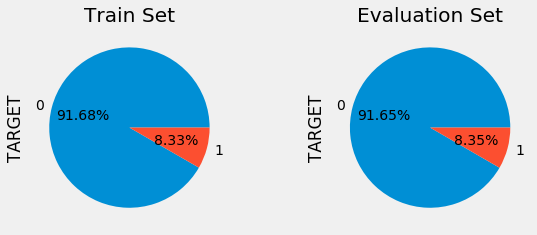

In [27]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
ytrain.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set');
yeval.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Evaluation Set');
fig.subplots_adjust(wspace=0.5);

In [28]:
# impute missing values
imputer = SimpleImputer(strategy='median')

imputer.fit(Xtrain)

xtrain = pd.DataFrame(imputer.transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
xeval = pd.DataFrame(imputer.transform(Xeval), index=Xeval.index, columns=Xeval.columns)

In [29]:
# Scale each feature to 0-1
scaler = MinMaxScaler()
scaler.fit(xtrain)

xtrain = pd.DataFrame(scaler.transform(xtrain), index=xtrain.index, columns=xtrain.columns)
xeval = pd.DataFrame(scaler.transform(xeval), index=xeval.index, columns=xeval.columns)

# Testing models

Modèles testés :
- Logistic Regression
- Random Forest Classifier
- Light GBM

Méthodes de rééquilibrage des classes :
- paramètre `class_weight = 'balanced'`
- SMOTE pour augmenter le nombre d'observations de la classe minoritaire
- Undersampling aléatoire pour diminuer le nombre d'observations de la classe majoritaire

Métrique utilisée :
- Fonction de coût personnalisée qui optimise les gains pour la banque (voir ci-dessous)

### Métrique personnalisée

In [11]:
def bank_score(y_true, y_pred):
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # We set the bank's gain and loss for each case
    FN_value = -10  # The loan is granted but the customer defaults (Type-II Error) 
    TN_value = 1    # The loan is reimbursed
    TP_value = 0    # The loan is (rightly) refused
    FP_value = 0    # Loan is refused by mistake (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    return score

b_score = make_scorer(bank_score)

## 1. Logistic Regression

### A) Baseline

In [12]:
# create model
lr = LogisticRegression()

# prepare table of results
df_scores = pd.DataFrame(index=['Baseline', 'Balanced class_weight', 'Smote', 'Random Undersample'])

We create a function that computes the cross-validation score and returns the probabilities for class 1

In [14]:
def cv_score_sample(model, x, y, scoring, resampling=None, cv=5):
    cv_score = []
    y_pred_proba = []

    # create folds
    kf = KFold(n_splits=cv)
    
    for train_indices, valid_indices in kf.split(x):
        # Training data for the fold
        xtrn, ytrn = x.iloc[train_indices], y.iloc[train_indices]
        # Validation data for the fold
        xval, yval = x.iloc[valid_indices], y.iloc[valid_indices]

        # train
        if resampling is not None :
            # Resample train set
            xtrn_rs, ytrn_rs = resampling.fit_resample(xtrn, ytrn)
            model.fit(xtrn_rs, ytrn_rs)
        
        else:
            model.fit(xtrn, ytrn)

        # predict values on validation set
        ypred = model.predict(xval)
        
        # save probabilities for class 1
        yprob = model.predict_proba(xval)
        y_pred_proba+=(list(yprob[:,1]))

        # save score
        score = round(scoring(yval, ypred),3)
        cv_score.append(score)
    return np.array(cv_score), np.array(y_pred_proba)

In [15]:
cv_score, y_proba = cv_score_sample(lr, xtrain, ytrain, bank_score)

In [16]:
print(cv_score.mean().round(3))

0.018


### Threshold selection

In this section, we will see if setting an other threshold value for the predictions has an impact on the model's performances

In [17]:
def threshod_selection(Y_proba, Ytrain):
    
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = (Y_proba > threshold)*1
        score = bank_score(Ytrain, y_pred)
        scores.append(score)

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=101), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()

Best Threshold : 0.09
Best Score : 0.291


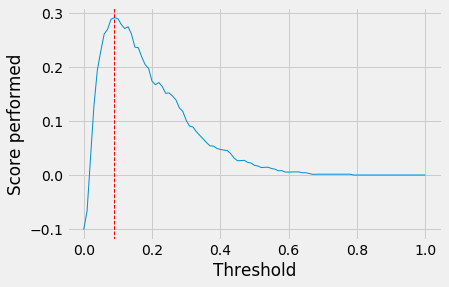

In [18]:
threshod_selection(y_proba, ytrain)

### Predictions and score on evaluation set

In [120]:
def predictions(model, x_train, y_train, x_eval, y_eval, threshold):
    model.fit(x_train, y_train)
    probas = model.predict_proba(x_eval)[:,1]
    predictions = (probas > threshold)*1
    
    # calculate bank_score
    val_score = round(bank_score(y_eval, predictions),3)
    cm=confusion_matrix(y_eval, predictions, normalize='true')*100
        
    # Display score & confusion matrix
    ax = sns.heatmap(cm, annot=True, cmap='RdBu', center=0, cbar=False)
    ax.set_title('Confusion matrix (%)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    print(f'Score on Evaluation set with threshold at {threshold} : {val_score}')

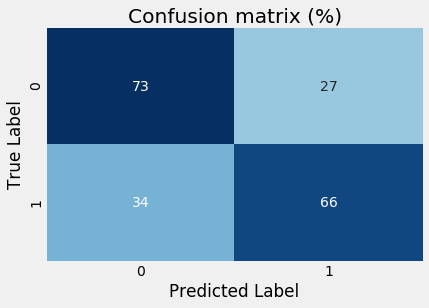

Score on validation set with threshold = 0.09 : 0.359


In [32]:
predictions(lr, xtrain, ytrain, xeval, yeval, threshold = 0.09)

In [33]:
# Save score performed on evaluation set
df_scores.loc['Baseline', 'Logistic Reg'] = 0.359

### B) With balanced class_weight
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.

Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

In [22]:
lrb = LogisticRegression(class_weight = 'balanced')

In [23]:
cv_score, y_proba = cv_score_sample(lrb, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.266


Best Threshold : 0.55
Best Score : 0.281


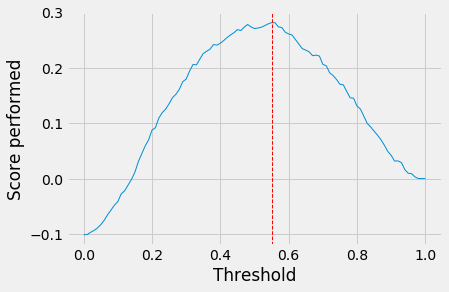

In [24]:
# Threshold selection
threshod_selection(y_proba, ytrain)

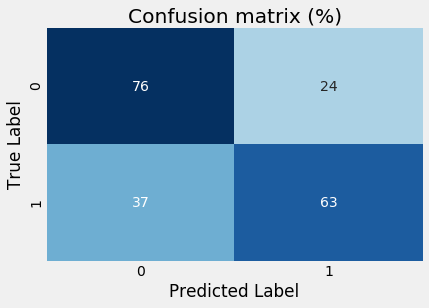

Score on Evaluation set with threshold at 0.55 : 0.363


In [121]:
# Predictions & score on evaluation set
predictions(lrb, xtrain, ytrain, xeval, yeval, threshold = 0.55)

In [35]:
df_scores.loc['Balanced class_weight', 'Logistic Reg'] = 0.363

### C) After over-sampling the minority class with SMOTE

SMOTE artificially creates more observations in the minority class to rebalance the distribution of the target value 

In [36]:
smote = SMOTE(random_state=6)
xsmot, ysmot = smote.fit_resample(xtrain, ytrain)

In [37]:
print(xtrain.shape, xsmot.shape)

(8000, 247) (14668, 247)


In [38]:
print(Counter(ytrain))
print(Counter(ysmot))

Counter({0: 7334, 1: 666})
Counter({0: 7334, 1: 7334})


In [39]:
cvscore, y_proba = cv_score_sample(lr, xtrain, ytrain, bank_score, resampling=smote)
print(cvscore.mean().round(3))

0.272


Best Threshold : 0.53
Best Score : 0.283


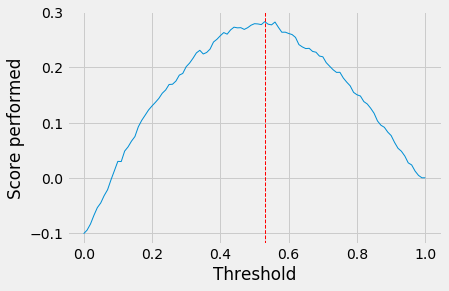

In [40]:
# Threshold selection
threshod_selection(y_proba, ytrain)

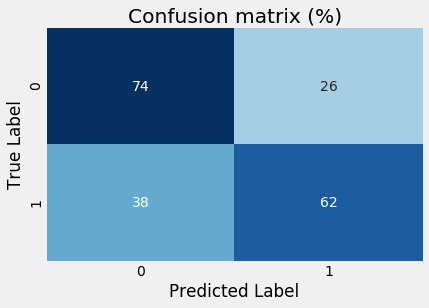

Score on validation set with threshold = 0.53 : 0.337


In [41]:
# Predictions & score on evaluation set
predictions(lr, xsmot, ysmot, xeval, yeval, threshold = 0.53)

In [42]:
df_scores.loc['Smote', 'Logistic Reg'] = 0.337

### D) After under-sampling the majority class

In [43]:
rus = RandomUnderSampler(random_state=6)
xresampled, yresampled = rus.fit_resample(xtrain, ytrain)

print(Counter(ytrain))
print(Counter(yresampled))

Counter({0: 7334, 1: 666})
Counter({0: 666, 1: 666})


In [44]:
cvscore, y_proba_rus = cv_score_sample(lr, xtrain, ytrain, bank_score, resampling=rus)
print(cvscore.mean().round(3))

0.251


Best Threshold : 0.46
Best Score : 0.269


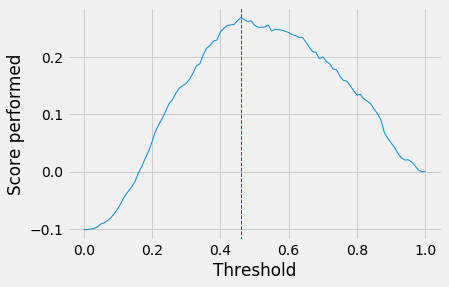

In [45]:
# Threshold selection
threshod_selection(y_proba_rus, ytrain)

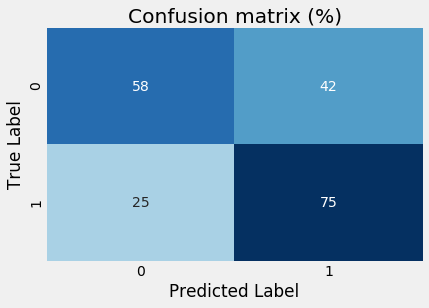

Score on validation set with threshold = 0.46 : 0.293


In [46]:
# Predictions & score on evaluation set
predictions(lr, xresampled, yresampled, xeval, yeval, threshold = 0.46)

In [47]:
df_scores.loc['Random Undersample', 'Logistic Reg'] = 0.293

### Synthetic Results for Logistic Regression

In [48]:
df_scores.sort_values('Logistic Reg', ascending=False)

,Logistic Reg
Balanced class_weight,0.363
Baseline,0.359
Smote,0.337
Random Undersample,0.293


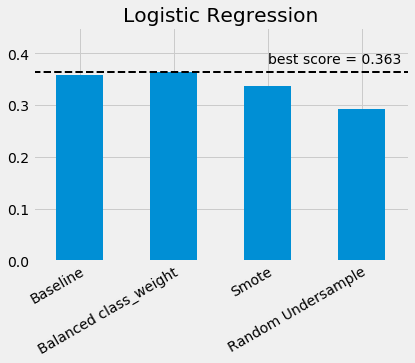

In [49]:
ax = df_scores.plot.bar(legend=None);
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.38, ('best score = {}'.format(df_scores['Logistic Reg'].max())), color='black');
plt.axhline(df_scores['Logistic Reg'].max(), ls='--', lw=2, c='black');
plt.title('Logistic Regression');

Best score ist obtained on model with balanced class_weight with threshold = 0.55.  
In this configuration, **76% of the non-default clients** and **63% of the default clients** are correctly detected

## 2. Improved Model: Random Forest

Let's try using a Random Forest on the same training data to see how that affects performance. We will first tune the hyperparameters to get better scores.

In [79]:
# Grid Search
random_forest = RandomForestClassifier(random_state = 21)

rf_params={ 'class_weight' : ['balanced'],
    'max_features': ['sqrt', None],
    'max_depth': [5, 10, None],
    'min_samples_leaf' : [1, 16, 64]}

rf_random = GridSearchCV(random_forest, rf_params, cv = 5, 
                               scoring = b_score, verbose=200)
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10 
[CV]  class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, score=0.233, total=   8.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[CV] class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10 
[CV]  class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, score=0.358, total=   9.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.3s remaining:    0.0s
[CV] class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10 
[CV]  class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, score=0.230, total=   9.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[CV] class_weight=balanced, max_depth=5, max_feat

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=21,
                                  

In [72]:
rf_cv = pd.DataFrame(rf_random.cv_results_).drop('params',axis=1)
rf_cv.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,7.821511,0.149878,0.028802,0.001612,64,None,5,balanced,0.236090,0.403008,0.266917,0.295489,0.324627,0.305226,0.057061,1
8,8.168970,0.219999,0.028175,0.001410,32,None,5,balanced,0.254135,0.380451,0.246617,0.302256,0.302239,0.297139,0.047739,2
0,10.832262,0.092921,0.031357,0.001357,64,None,10,balanced,0.226316,0.378195,0.229323,0.292481,0.342537,0.293771,0.060351,3
7,10.975644,0.126540,0.033446,0.001295,64,None,20,balanced,0.227820,0.357895,0.229323,0.287218,0.343284,0.289108,0.054773,4
5,0.955398,0.008262,0.033511,0.001794,64,sqrt,10,balanced,0.202256,0.333835,0.265414,0.311278,0.273881,0.277333,0.045023,5
2,0.714786,0.012078,0.032702,0.001546,32,sqrt,5,balanced,0.215789,0.340602,0.245865,0.308271,0.271642,0.276434,0.044196,6
6,1.068354,0.011627,0.034583,0.001358,32,sqrt,10,balanced,0.181955,0.348872,0.241353,0.224812,0.258955,0.251190,0.055115,7
9,13.034013,0.162492,0.034597,0.001763,32,None,None,balanced,0.181955,0.306015,0.184962,0.273684,0.295522,0.248428,0.054071,8
1,1.194144,0.026327,0.036699,0.001467,32,sqrt,20,balanced,0.182707,0.310526,0.194737,0.214286,0.250000,0.230451,0.046066,9
3,1.186881,0.017414,0.037819,0.001413,32,sqrt,None,balanced,0.177444,0.303008,0.195489,0.214286,0.252239,0.228493,0.044751,10


### A) Baseline

In [50]:
random_forest = RandomForestClassifier(random_state = 21, 
                                       max_depth = 5, 
                                       max_features = None, 
                                       min_samples_leaf = 64)

In [51]:
cv_score, y_proba = cv_score_sample(random_forest, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.0


The score is null, meaning that all observations were predicted = 0

Best Threshold : 0.08
Best Score : 0.279


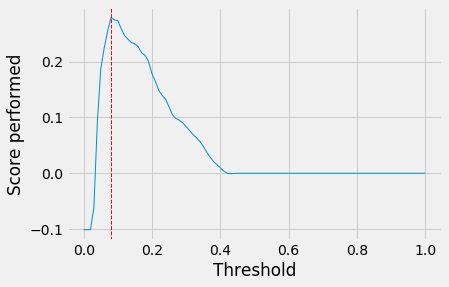

In [52]:
# Threshold selection
threshod_selection(y_proba, ytrain)

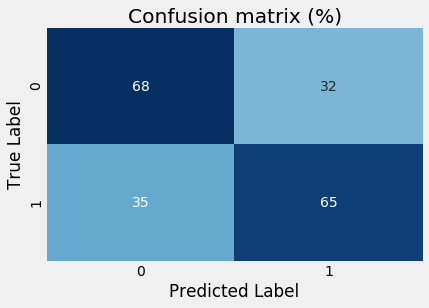

Score on validation set with threshold = 0.08 : 0.301


In [53]:
# Predictions & score on evaluation set
predictions(random_forest, xtrain, ytrain, xeval, yeval, threshold = 0.08)

In [54]:
df_scores.loc['Baseline', 'Random Forest'] = 0.301

### B) With balanced class_weight

In [55]:
random_forest_b = RandomForestClassifier(random_state = 21, 
                                         max_depth = 5, 
                                         max_features = None, 
                                         min_samples_leaf = 64,
                                         class_weight = 'balanced')

In [56]:
cv_score, y_proba = cv_score_sample(random_forest_b, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.297


Best Threshold : 0.5
Best Score : 0.3


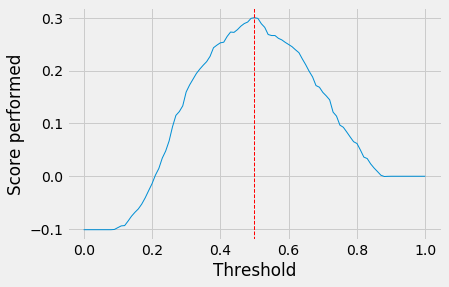

In [57]:
# Threshold selection
threshod_selection(y_proba, ytrain)

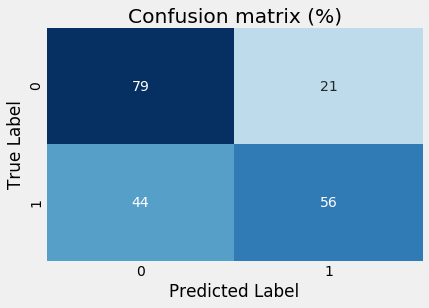

Score on validation set with threshold = 0.5 : 0.335


In [58]:
# Predictions & score on evaluation set
predictions(random_forest_b, xtrain, ytrain, xeval, yeval, threshold = 0.5)

In [59]:
df_scores.loc['Balanced class_weight', 'Random Forest'] = 0.335

### C) After over-sampling the minority class with SMOTE

In [60]:
cv_score, y_proba_smot = cv_score_sample(random_forest, xtrain, ytrain, bank_score, resampling=smote)
print(cv_score.mean().round(3))

0.158


Best Threshold : 0.39
Best Score : 0.187


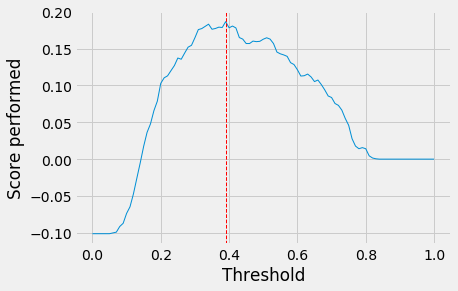

In [61]:
# Threshold selection
threshod_selection(y_proba_smot, ytrain)

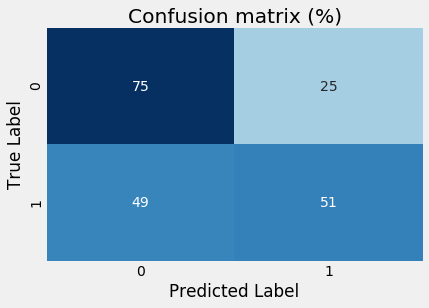

Score on validation set with threshold = 0.39 : 0.231


In [62]:
# Predictions & score on evaluation set
predictions(random_forest, xsmot, ysmot, xeval, yeval, threshold = 0.39)

In [63]:
df_scores.loc['Smote', 'Random Forest'] = 0.231

### D) After under-sampling the majority class

In [64]:
cv_score, y_proba_rus = cv_score_sample(random_forest, xtrain, ytrain, bank_score, resampling=rus)
print(cv_score.mean().round(3))

0.269


Best Threshold : 0.53
Best Score : 0.285


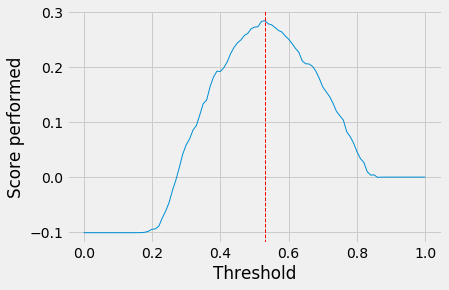

In [65]:
# Threshold selection
threshod_selection(y_proba_rus, ytrain)

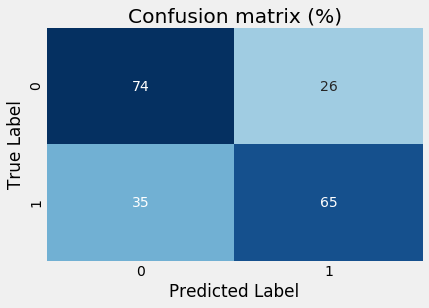

Score on validation set with threshold = 0.53 : 0.36


In [66]:
# Predictions & score on evaluation set
predictions(random_forest, xresampled, yresampled, xval, yval, threshold = 0.53)

In [67]:
df_scores.loc['Random Undersample', 'Random Forest'] = 0.36

### Summary Results

In [68]:
df_scores.sort_values('Random Forest', ascending=False)

,Logistic Reg,Random Forest
Random Undersample,0.293,0.360
Balanced class_weight,0.363,0.335
Baseline,0.359,0.301
Smote,0.337,0.231


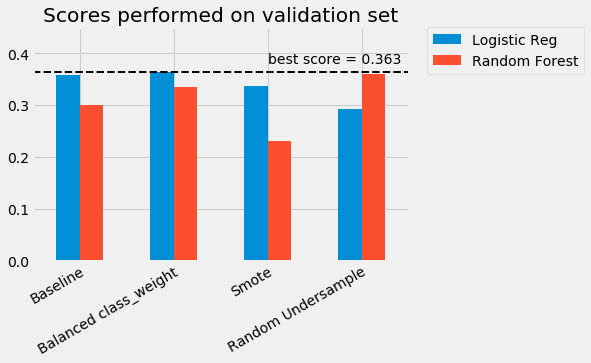

In [69]:
ax = df_scores.plot.bar()
plt.title('Scores performed on Eval set')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.38, ('best score = {}'.format(df_scores.max().max())), color='black')
plt.axhline(df_scores.max().max(), ls='--', lw=2, c='black');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

#### The best score for Random Forest is obtained on the undersampled data. But Logistic Regression still performs better

## 3. Light GBM

This model handles missing values so we will use the raw data (without preprocessing)

In [70]:
# Reformating column names
Xtrain.columns = ["".join (c if c.isalnum() else " " for c in str(x)) for x in Xtrain.columns]
Xeval.columns = ["".join (c if c.isalnum() else " " for c in str(x)) for x in Xeval.columns]

In [120]:
lgbc = lgb.LGBMClassifier()

params = {'class_weight' : ['balanced'],
          'objective' : ['binary'],
          'boosting' : ['gbdt', 'dart', 'goss'],
          'n_estimators': [500], 
          'learning_rate' : [0.01],
          'max_depth' : [5, 10, 20, None],
          'num_leaves' : [4, 16, 64, 128],
          'min_data_in_leaf' : [10, 50, 100, 500]
         }

lgb_random = RandomizedSearchCV(lgbc, params, n_iter = 30, cv = 5, scoring = b_score, verbose=500)

lgb_random.fit(Xtrain, ytrain)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.234, total=   2.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.341, total=   2.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500

[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.177, total=   6.4s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.0min remaining:    0.0s
[CV] objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss 
[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.333, total=   6.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  2.1min remaining:    0.0s
[CV] objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss 
[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.198, total=   6.9s
[Paral

[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=10, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.377, total=   1.6s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  3.5min remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=10, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=goss 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=10, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.279, total=   1.9s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  3.6min remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=10, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=goss 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=10, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.254, total=   1.5s
[Parallel(n_jobs=1)]:

[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.144, total=  39.5s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  6.6min remaining:    0.0s
[CV] objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.256, total=  38.8s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  7.2min remaining:    0.0s
[CV] objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.168, total=  44

[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.195, total=  22.6s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 10.0min remaining:    0.0s
[CV] objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss 
[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=10, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=goss, score=0.140, total=  23.2s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed: 10.4min remaining:    0.0s
[CV] objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=500, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=gbdt 
[CV]  objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=500, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=gbdt, score=0.263, total=   2.3s
[Paral

[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=gbdt, score=0.304, total=  11.4s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 11.9min remaining:    0.0s
[CV] objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.270, total=   6.8s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed: 12.0min remaining:    0.0s
[CV] objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.365, total=   

[CV]  objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=500, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=gbdt, score=0.390, total=   2.6s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.6min remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=gbdt 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=gbdt, score=0.311, total=   1.9s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed: 15.6min remaining:    0.0s
[CV] objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=gbdt 
[CV]  objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=50, max_depth=5, learning_rate=0.01, class_weight=balanced, boosting=gbdt, score=0.380, total=   1.8s
[Parallel(n_jobs=

[CV]  objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.230, total=  11.9s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed: 17.0min remaining:    0.0s
[CV] objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.376, total=  12.7s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed: 17.2min remaining:    0.0s
[CV] objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=dart 
[CV]  objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, class_weight=balanced, boosting=dart, score=0.262, total=  12.5s
[Paral

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                   param_distributions={'boosting': ['gbdt', 'dart', 'goss'],
                                        'class_

In [121]:
res = pd.DataFrame(lgb_random.cv_results_).drop('params',axis=1)
res.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_num_leaves,param_n_estimators,param_min_data_in_leaf,param_max_depth,param_learning_rate,param_class_weight,param_boosting,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,2.033217,0.074502,0.116084,0.004312,binary,64,500,500,5,0.01,balanced,gbdt,0.295489,0.400000,0.287970,0.239098,0.382090,0.320929,0.060700,1
15,1.757987,0.028793,0.108887,0.002196,binary,4,500,50,10,0.01,balanced,gbdt,0.311278,0.380451,0.294737,0.265414,0.342537,0.318883,0.039623,2
25,1.806982,0.141345,0.108489,0.003663,binary,4,500,50,5,0.01,balanced,gbdt,0.311278,0.380451,0.294737,0.265414,0.342537,0.318883,0.039623,2
14,1.578471,0.217248,0.164904,0.091335,binary,4,500,500,None,0.01,balanced,gbdt,0.282707,0.414286,0.296241,0.247368,0.325373,0.313195,0.056423,4
24,2.400362,0.128192,0.120995,0.005959,binary,128,500,500,20,0.01,balanced,gbdt,0.263158,0.355639,0.290977,0.254887,0.389552,0.310843,0.052918,5


In [123]:
print(lgb_random.best_score_)
print(lgb_random.best_params_)

0.32092918864324993
{'objective': 'binary', 'num_leaves': 64, 'n_estimators': 500, 'min_data_in_leaf': 500, 'max_depth': 5, 'learning_rate': 0.01, 'class_weight': 'balanced', 'boosting': 'gbdt'}


### A) Baseline

In [71]:
lgbc = lgb.LGBMClassifier(objective = 'binary', 
                         num_leaves = 64, 
                         n_estimators = 500, 
                         min_data_in_leaf = 500, 
                         max_depth = 5, 
                         learning_rate = 0.01, 
                         #class_weight = 'balanced', 
                         boosting = 'gbdt', 
                         random_state = 21)

In [72]:
cv_score, y_proba = cv_score_sample(lgbc, Xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.0


Best Threshold : 0.12
Best Score : 0.3


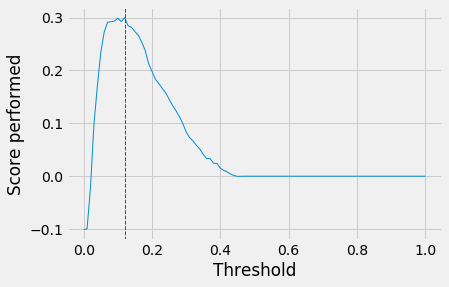

In [73]:
# Threshold selection
threshod_selection(y_proba, ytrain)

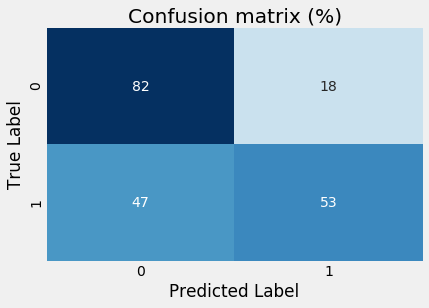

Score on validation set with threshold = 0.12 : 0.325


In [74]:
# Predictions & score on evaluation set
predictions(lgbc, Xtrain, ytrain, Xeval, yeval, threshold = 0.12)

In [75]:
df_scores.loc['Baseline', 'Light GBM'] = 0.325

### B) With balanced class_weight

In [76]:
lgbc = lgb.LGBMClassifier(objective = 'binary', 
                         num_leaves = 64, 
                         n_estimators = 500, 
                         min_data_in_leaf = 500, 
                         max_depth = 5, 
                         learning_rate = 0.01, 
                         class_weight = 'balanced', 
                         boosting = 'gbdt', 
                         random_state = 21)

In [77]:
cv_score, y_proba = cv_score_sample(lgbc, Xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.31


Best Threshold : 0.5
Best Score : 0.314


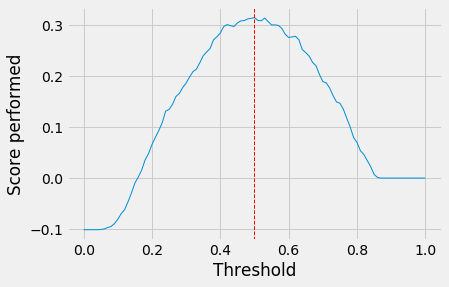

In [132]:
# Threshold selection
threshod_selection(y_proba, ytrain)

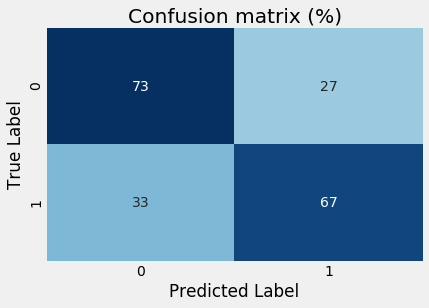

Score on validation set with threshold = 0.5 : 0.372


In [78]:
# Predictions & score on evaluation set
predictions(lgbc, Xtrain, ytrain, Xeval, yeval, threshold = 0.5)

In [79]:
df_scores.loc['Balanced class_weight', 'Light GBM'] = 0.372

### C) SMOTE
We can't oversample the minority class since our training data set contains missing values

### D) After under-sampling the majority class

In [80]:
Xrus, yrus = rus.fit_resample(Xtrain, ytrain)

In [81]:
cv_score, y_proba_rus = cv_score_sample(lgbc, Xtrain, ytrain, bank_score, resampling=rus)
print(cv_score.mean().round(3))

0.243


Best Threshold : 0.5700000000000001
Best Score : 0.275


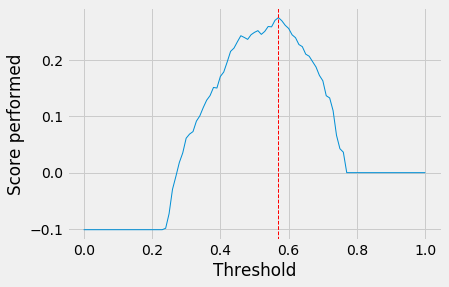

In [82]:
threshod_selection(y_proba_rus, ytrain)

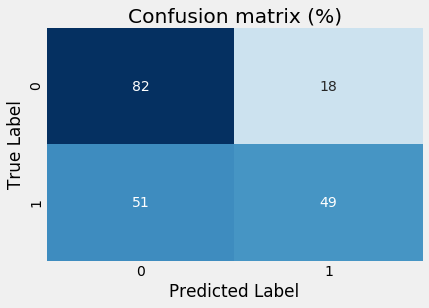

Score on validation set with threshold = 0.57 : 0.289


In [83]:
# Predictions & score on evaluation set
predictions(lgbc, Xrus, yrus, Xeval, yeval, threshold = 0.57)

In [84]:
df_scores.loc['Random Undersample', 'Light GBM'] = 0.289

## Final Results

In [85]:
df_scores

,Logistic Reg,Random Forest,Light GBM
Baseline,0.359,0.301,0.325
Balanced class_weight,0.363,0.335,0.372
Smote,0.337,0.231,NaN
Random Undersample,0.293,0.360,0.289


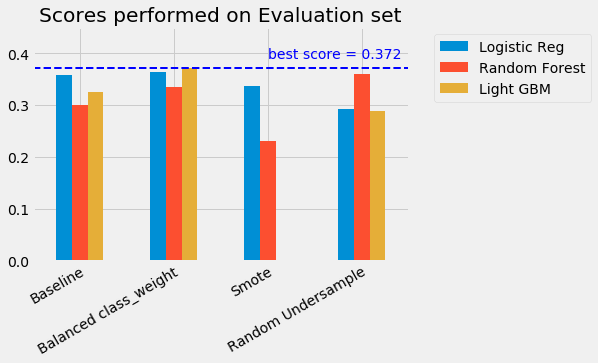

In [119]:
ax = df_scores.plot.bar()
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.39, ('best score = {}'.format(df_scores.max().max())), color='b')
plt.axhline(df_scores.max().max(), ls='--', lw=2, c='b');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title('Scores performed on Evaluation set');

#### We can conclude that the best model is Light GBM with balanced class_weight and threshold = 0.5

## Feature Importances

In [89]:
random_forest_b.fit(xtrain, ytrain)
lgbc.fit(Xtrain, ytrain)

rf_feat_imp = pd.DataFrame(random_forest_b.feature_importances_, index=X.columns, columns=['Random Forest'])
lgb_feat_imp = pd.DataFrame(lgbc.feature_importances_, index=X.columns, columns=['Light GBM'])

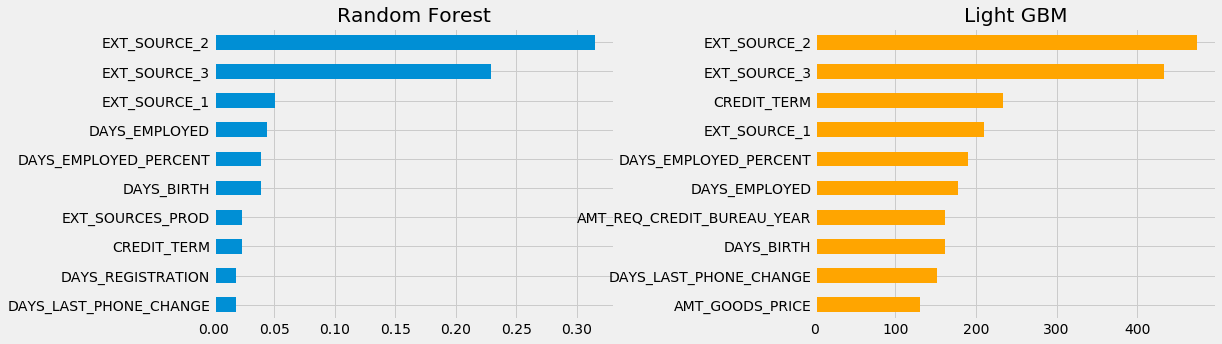

In [90]:
# Plot 10 most important features for Random Forest & Light GBM
fig, ax = plt.subplots(1, 2, figsize=(16,5) )
rf_feat_imp.sort_values('Random Forest')[-10::].plot.barh(ax=ax[0], legend= None);
lgb_feat_imp.sort_values('Light GBM')[-10::].plot.barh(ax=ax[1], color='orange', legend=None);
ax[0].set_title('Random Forest')
ax[1].set_title('Light GBM')
fig.subplots_adjust(wspace=0.5);

Almost the same features are observed in the top 10 most important for both models. We also find some of our engineered features (CREDIT TERM, DAYS EMPLOYED PERCENT, EXT SOURCE PROD)  

### Save fitted model

In [91]:
import pickle 
with open('light_gbm.pickle', 'wb') as file :
    pickle.dump(lgbc, file)

# IV Model interpretation with SHAP

In [8]:
import shap
shap.initjs()

In [9]:
import pickle
with open('light_gbm.pickle', 'rb') as file : 
    LGB = pickle.load(file)

In [10]:
explainer = shap.TreeExplainer(LGB, model_output = 'probability',
                               data = Xtrain.sample(200),
                              feature_dependence='independent' )
shap_values = explainer.shap_values(Xeval, yeval)

100%|===================| 1992/2000 [01:01<00:00]        

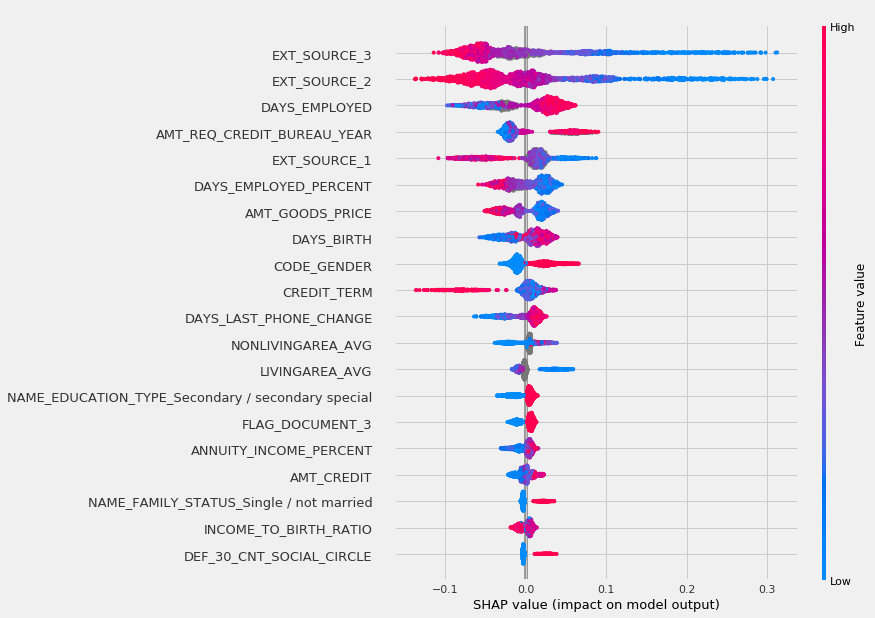

In [11]:
shap.summary_plot(shap_values, Xeval)

In [21]:
def ABS_SHAP(df_shap,df):
    
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[227::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6), legend=False)
    ax.set_title("SHAP Value \nHigh value for feature in Red = more risk of default")
 

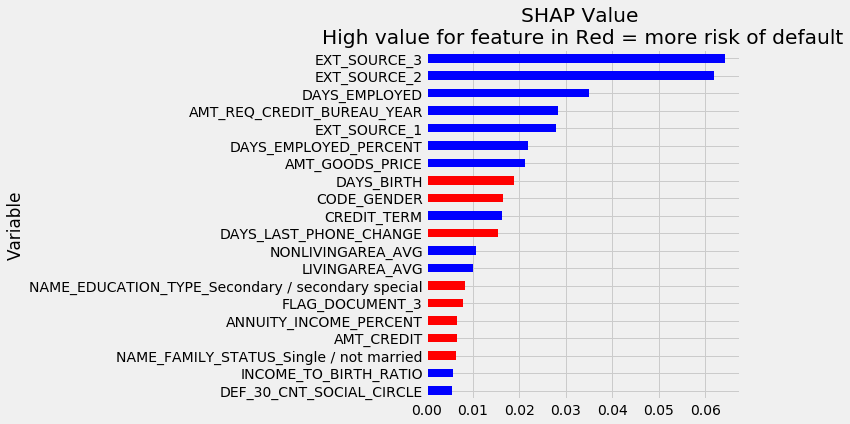

In [22]:
ABS_SHAP(shap_values, Xeval)

In [18]:
explainer.expected_value

0.38982216654782953

In [19]:
def shap_plot(i):
    print(LGB.predict_proba(Xeval.iloc[i:i+1]).round(2))
    print('True class :', yeval.iloc[i])
    return(shap.force_plot(explainer.expected_value, shap_values[i], Xeval.iloc[i]))

In [20]:
shap_plot(0)

[[0.45 0.55]]
True class : 0


In [23]:
shap_plot(7)

[[0.76 0.24]]
True class : 0


In [14]:
shap_plot(128)

[[0.24 0.76]]
True class : 1


In [15]:
shap_plot(90)

[[0.83 0.17]]
True class : 0


In [25]:
shap_plot(921)

[[0.8 0.2]]
True class : 0
